In [1]:
# from kcorrect.kcorrect import Kcorrect
import pandas as pd
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import seaborn as sns
import matplotlib.pyplot as plt

path = '/home/gimena/Documents/hsc/scripts/add_features/'  #of this file

### Create yanny files 

In [2]:
# import kcorrect
# sorted(kcorrect.response.all_responses())

filter_files = [# list of files with response functions (from https://hsc.mtk.nao.ac.jp/ssp/survey/#filters_and_depths)
    'hsc_g_v2018',
    'hsc_r2_v2018',
    'hsc_i2_v2018',
    'hsc_z_v2018',
    'hsc_y_v2018'
]

In [ ]:
table_names = ['GFILTER', 'RFILTER', 'IFILTER', 'ZFILTER', 'YFILTER']

# convert them to yanny parameter files...
# Kcorrect does have some response functions for subaru, but it's missing the Y filter. Also, the i and r filters were changed in 2016 (see HSC-SSP DR2 note).
responses = []
for fil,nam in zip(filter_files,table_names):
    f = pd.read_table(f'hsc_responses_all_rev4/{fil}.dat', names = ['w','r'], delim_whitespace= True)
    f.insert(0, 'a', nam)  #name of the table
    
    with open(f'par_responses/{fil}.par', 'w') as par:
        par.write('typedef struct {\n')
        par.write(' float lambda;\n')
        par.write(' float pass;\n')
        par.write('} '+nam+';\n\n')

        dfAsString = f.to_string(header=False, index=False)
        par.write(dfAsString)
del f,fil

### Create Kcorrect instance and fit coefficients. Check distribution and errors.

In [27]:
# list of par files for each filter, with ABSOLUT PATH
responses = [path + 'par_responses/' + fil for fil in filter_files]
kc = Kcorrect(responses = responses, abcorrect= False, redshift_range= [0., 5], nredshift = 7000, cosmo= FlatLambdaCDM(H0=70, Om0=0.3))

# I increased the upper limit for redshift, to be able to compute absolute magnitudes with a band shift later

In [4]:
df = pd.read_csv('../../clean-HSC-unWISE-W02.csv')
magnitudes = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
errors = ['g_cmodel_magsigma', 'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma', 'y_cmodel_magsigma']
absorption = ['a_g', 'a_r', 'a_i', 'a_z', 'a_y']  

In [7]:
# convert the magnitudes to "maggies"
# maggies are a linear flux density unit defined as 10^{-0.4 m_AB}  where  m_AB is the AB apparent magnitude. 
# That is, 1 maggie is the flux density in Janskys divided by 3631. 

# https://www.sdss3.org/dr8/algorithms/magnitudes.php
# http://wiki.ipb.ac.rs/index.php/Astro_links

maggies = pd.DataFrame()
ivars = pd.DataFrame()
for mag,err,ab in zip(magnitudes, errors, absorption):
    maggies[mag] = [10**(-0.4 * (m - a)) for m,a in zip(df[mag].values, df[ab].values)]     # 10^[-0.4 * (m - a_ext)]
    ivars[mag]=[1./(0.4*np.log(10.)*maggie*e)**2 for e,maggie in zip(df[err].values, maggies[mag].values)]   # 1. / [0.4 * ln(10) * maggie * m_err]**2

In [8]:
coeffs,rnorms = kc.fit_coeffs(redshift = df['phot_z'].values, maggies = maggies.values, ivar = ivars.values, errors = True)  
# the docs says that it transforms maggies to the ab system.

# “NNLS quitting on iteration count.” 
# This indicates that the default number of iterations for scipy.optimize.nnls was not enough. 
# Under these conditions, this code tries a much larger number of iterations. If that still fails, you will receive a traceback.

# I edited kcorrect so that it returned the errors


 NNLS quitting on iteration count.


Text(0.5, 0, 'coeffs')

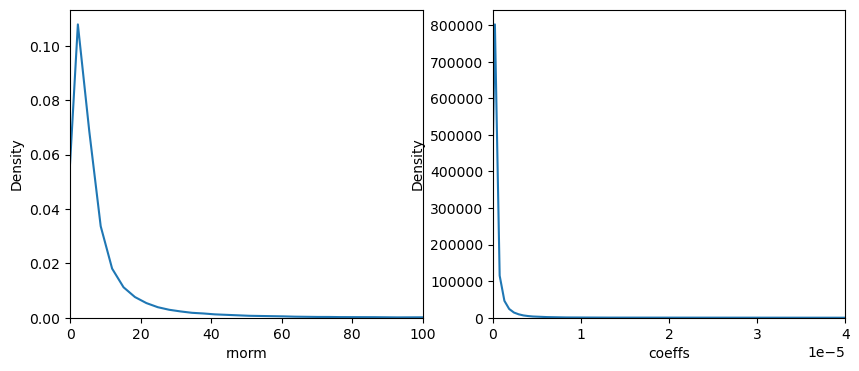

In [9]:
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
sns.kdeplot(x = rnorms)
plt.xlim(0,100)
plt.xlabel('rnorm')

plt.subplot(1, 2, 2)
sns.kdeplot(x = coeffs.flatten())
plt.xlim(0,0.00004)
plt.xlabel('coeffs')

### K-correction and distribution as function of z

In [10]:
kcorr = kc.kcorrect(redshift = df['phot_z'].values, coeffs = coeffs)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_k_corr'] = kcorr[:,i]

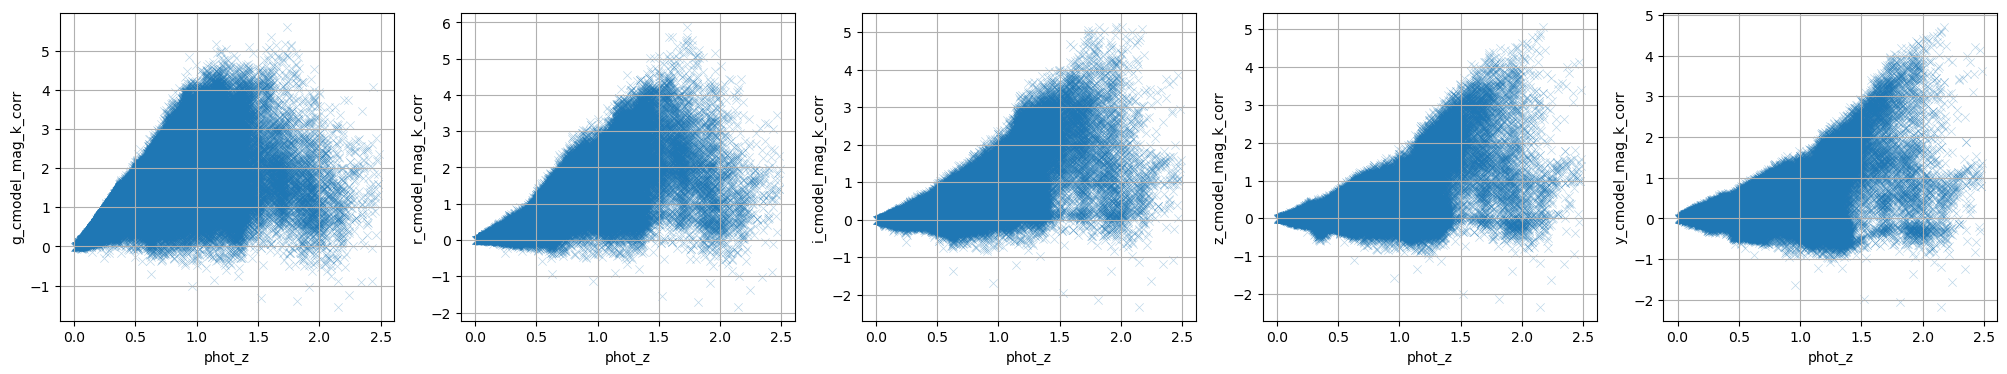

In [11]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.scatterplot(data = df, x = 'phot_z', y = magnitudes[i] + '_k_corr', marker = 'x', alpha = 0.3)
    plt.grid()

### Absolute magnitudes. Distributions and color-magnitude plots.

In [12]:
abs_mags = kc.absmag(redshift = df['phot_z'].values, maggies = maggies.values, ivar = ivars.values, coeffs = coeffs)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_abs'] = abs_mags[:,i]

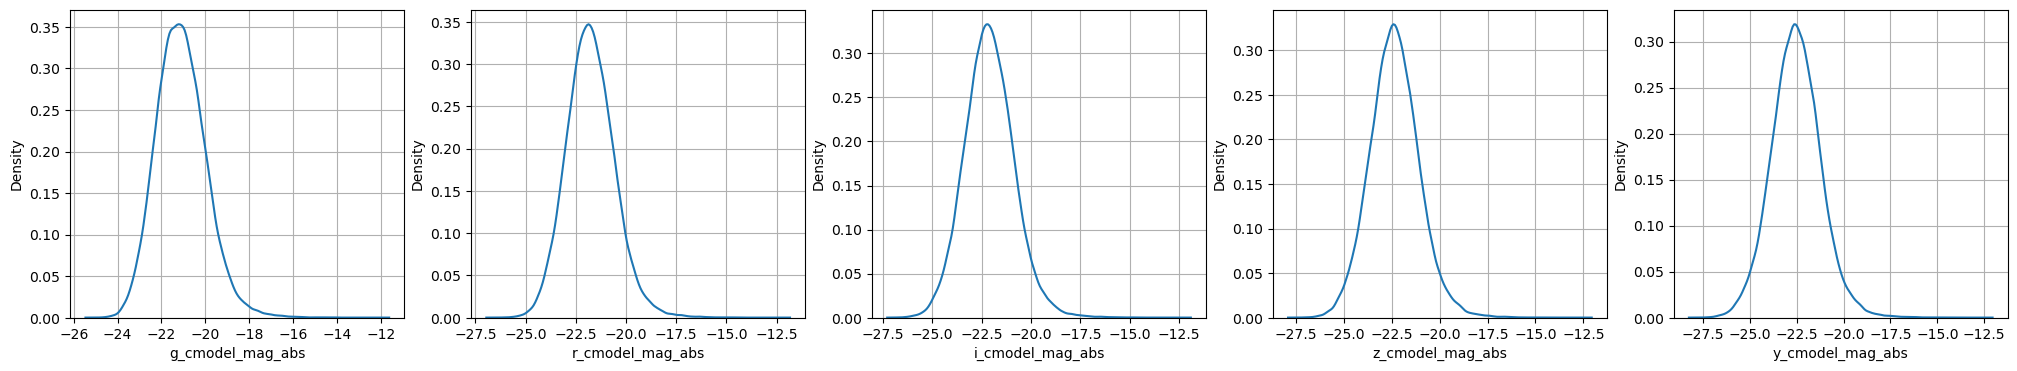

In [13]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.kdeplot(data = df, x = magnitudes[i] + '_abs')
    plt.grid()

In [24]:
df_cl = pd.read_table('../../clusters.dat', delim_whitespace=True, usecols=[0,5],  names=['id_cl','phot_z_cl'])
#  usecols=[0,3,4,5,9,11,12],  names=['id_cl','ra_cl','dec_cl','phot_z_cl', 'r500_cl','mass_cl','n500_cl']

df_ = pd.DataFrame()
df_['id_cl_near_eval'] = [eval(p)[0] for p in df.id_cl_near.values]
df_['z_cl'] = [df_cl[df_cl.id_cl == i]['phot_z_cl'].values[0] for i in df_.id_cl_near_eval]

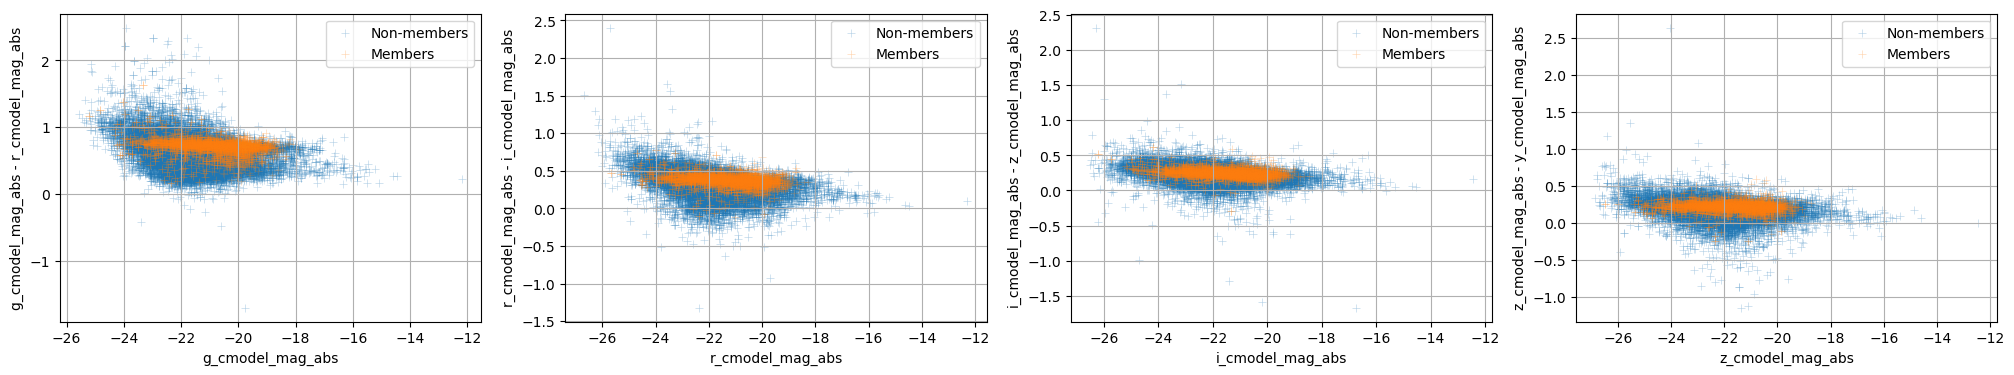

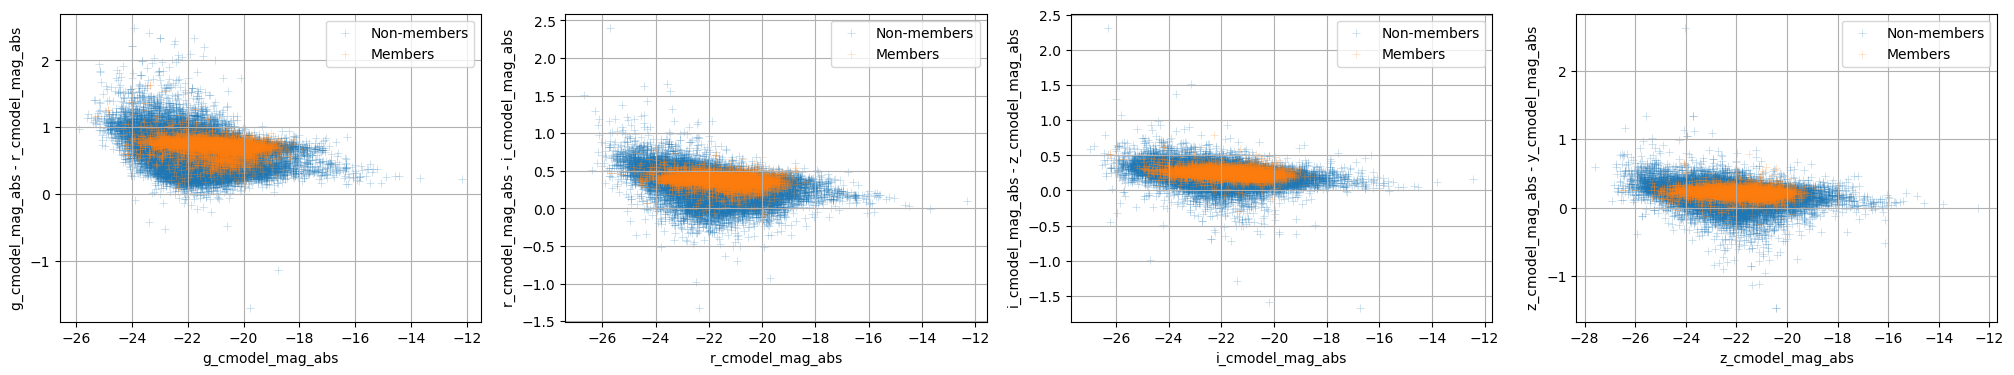

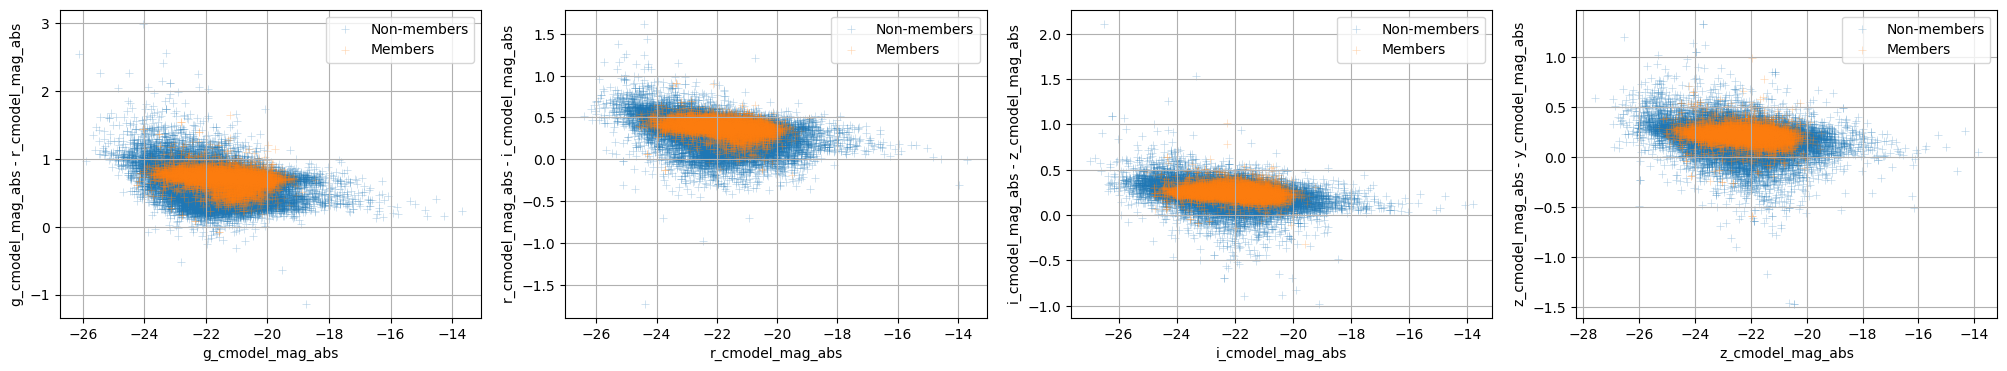

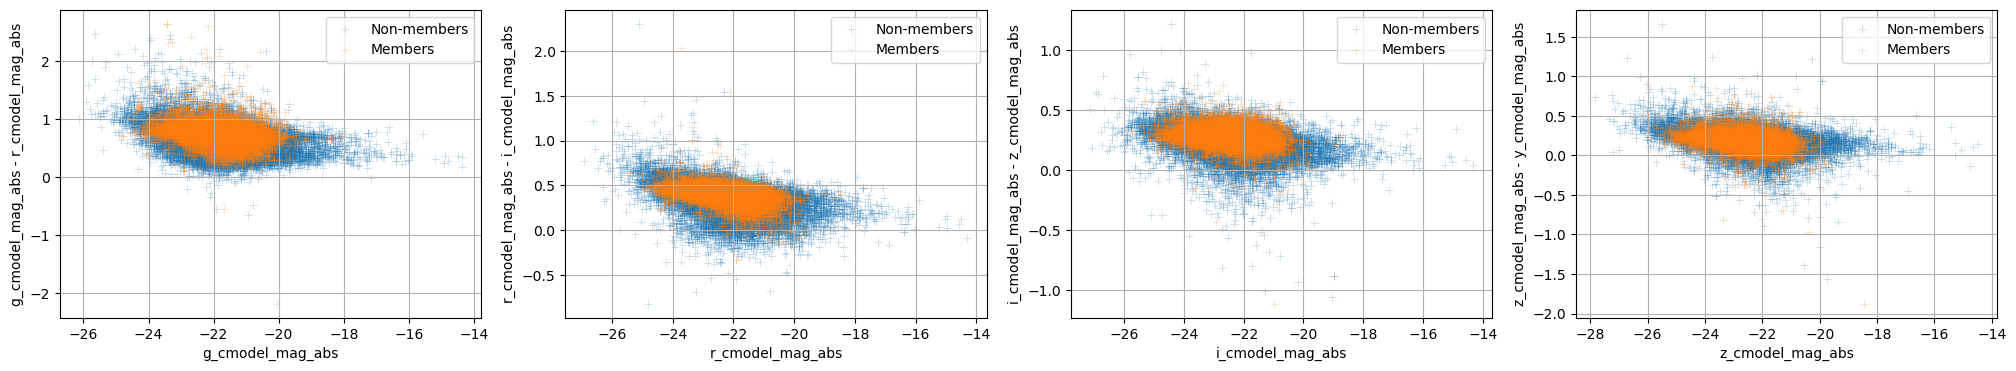

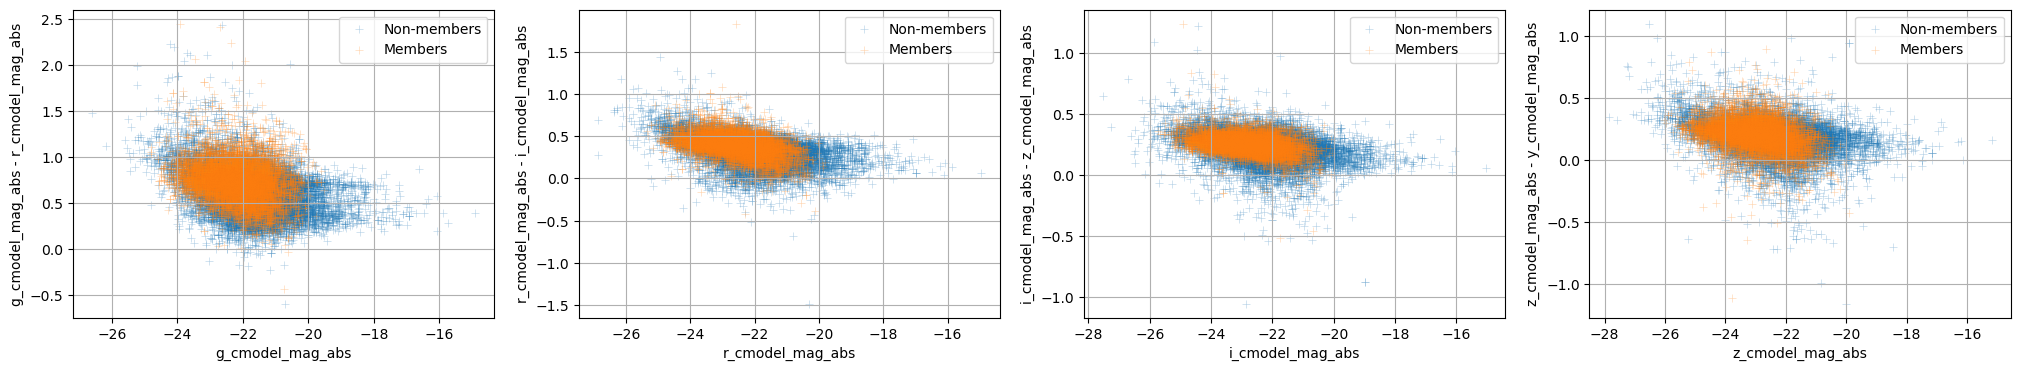

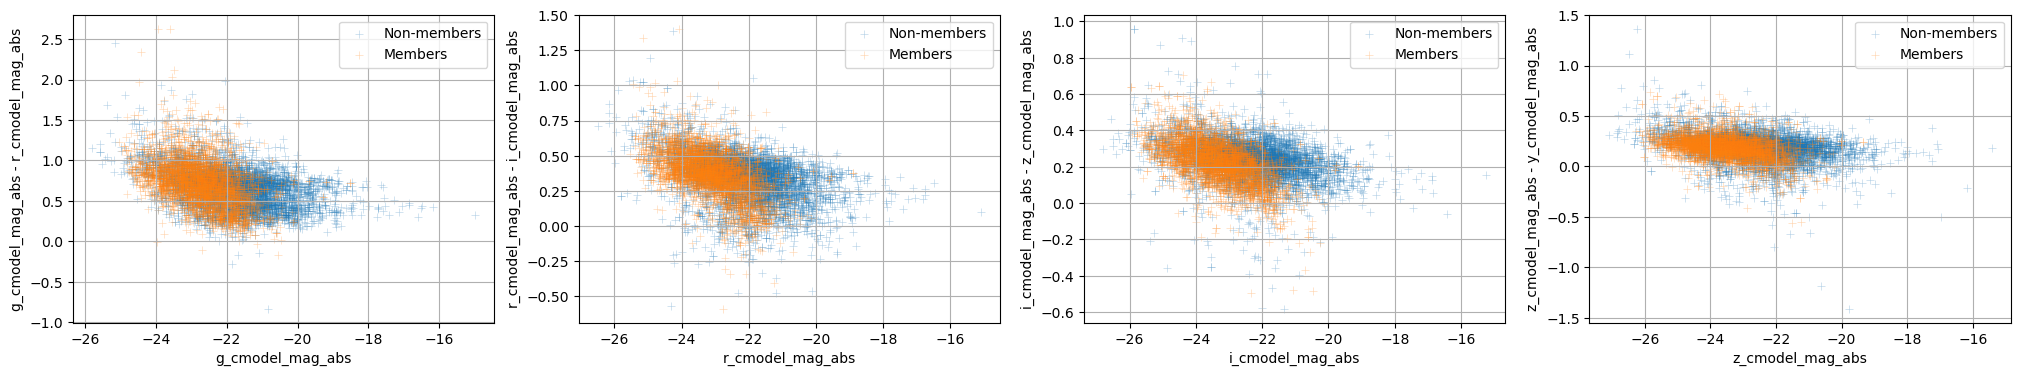

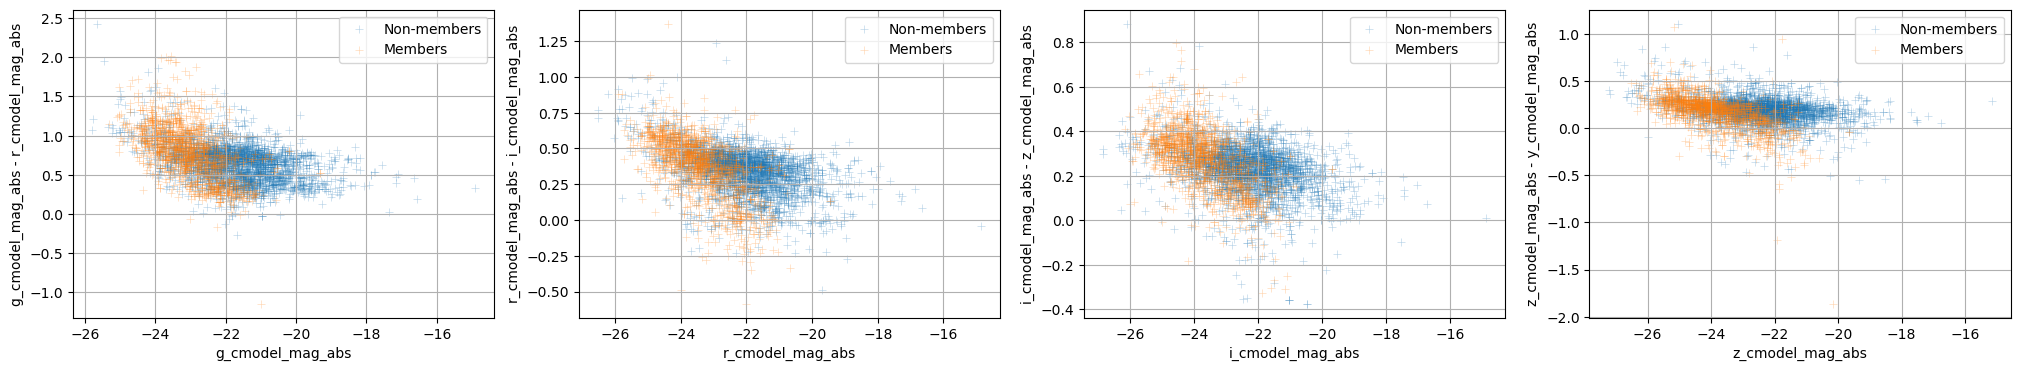

In [35]:
for z_min in [0,0.1,0.25,0.5,0.7,1.,1.25]:
    z_max = z_min + 0.25

    cond = (df_.z_cl > z_min ) & (df_.z_cl < z_max )
    mem = df[(df.member == 1) & cond] 
    nmem = df[(df.member == 0) & cond]

    plt.figure(figsize = (25,4))
    for i in range(4):
        plt.subplot(1,4,i+1)
        sns.scatterplot(y = nmem[magnitudes[i] + '_abs'] - nmem[magnitudes[i+1] + '_abs'], x = nmem[magnitudes[i+1]+ '_abs'], marker = '+', alpha = 0.3, label = 'Non-members')
        sns.scatterplot(y = mem[magnitudes[i] + '_abs'] - mem[magnitudes[i+1] + '_abs'], x = mem[magnitudes[i+1]+ '_abs'], marker = '+', alpha = 0.3, label = 'Members')
        plt.grid()
        plt.xlabel(f'{magnitudes[i]}_abs')
        plt.ylabel(f'{magnitudes[i]}_abs - {magnitudes[i+1]}_abs')
    plt.show()

### K-corrections with bandshift. Distribution plots. 

Mean:  0.726485642719
Median:  0.667


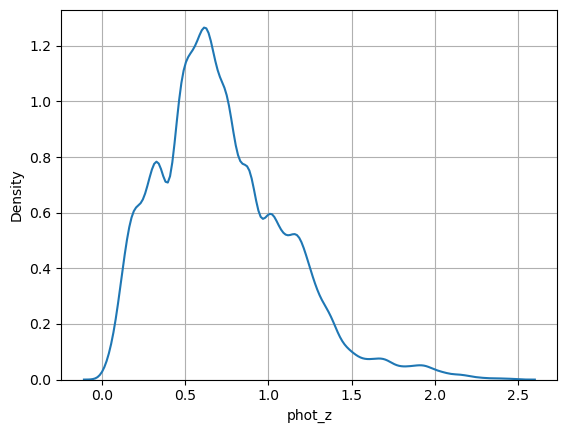

In [15]:
# check z distribution and mean value
sns.kdeplot(data = df, x = 'phot_z')
plt.grid()
print('Mean: ', np.mean(df.phot_z.values))
print('Median: ', np.median(df.phot_z.values))

In [16]:
shift = np.median(df.phot_z.values)
kcorr_shift = kc.kcorrect(redshift = df['phot_z'].values, coeffs = coeffs, band_shift= shift)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_k_corr_shift'] = kcorr_shift[:,i]

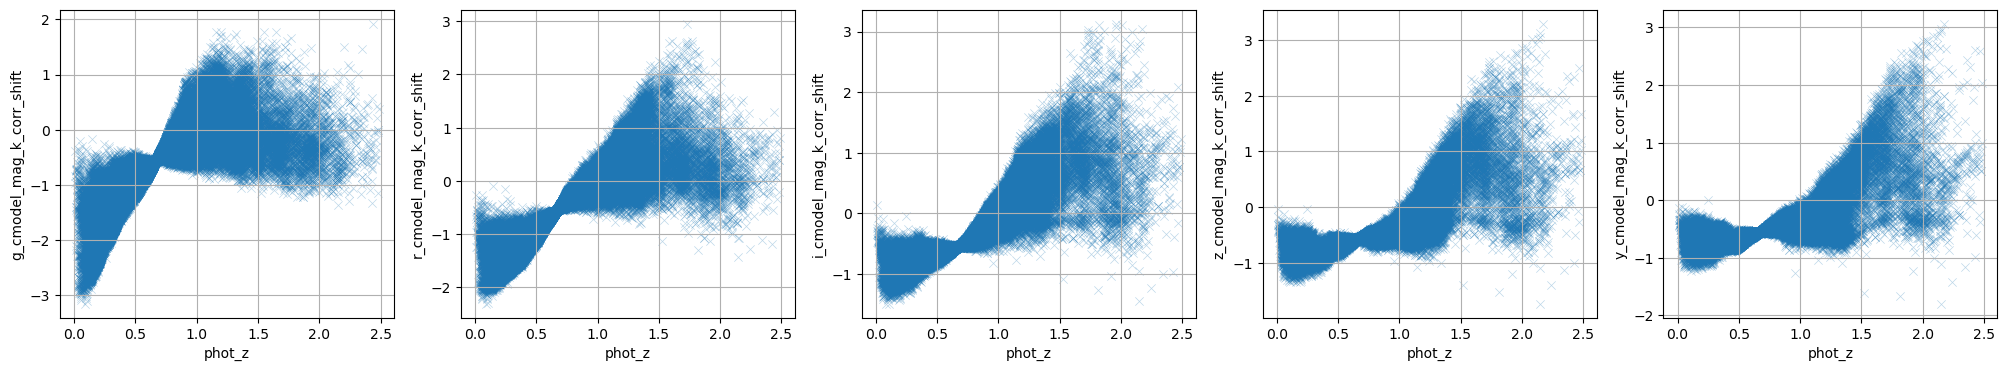

In [17]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.scatterplot(data = df, x = 'phot_z', y = magnitudes[i] + '_k_corr_shift', marker = 'x', alpha = 0.3)
    plt.grid()

In [18]:
# from kcorrect.org

# for a bandpass shifted by z_0, the K-correction for a galaxy at z_0 to the observed bandpass shifted by z_0 is −2.5log10(1+z_0), independent of galaxy SED. 

# in this case, this is:
print(-2.5 * np.log10(1 + shift))

-0.55483899957


### Absolute magnitudes with bandshift. Distributions and color-magnitude plots.

In [28]:
abs_mags_shift = kc.absmag(redshift = df['phot_z'].values, maggies = maggies.values, ivar = ivars.values, coeffs = coeffs, band_shift= shift)

# add to dataframe
for i,nam in enumerate(magnitudes):
    df[nam + '_abs_shift'] = abs_mags_shift[:,i]
    
# idk why this does not work. 

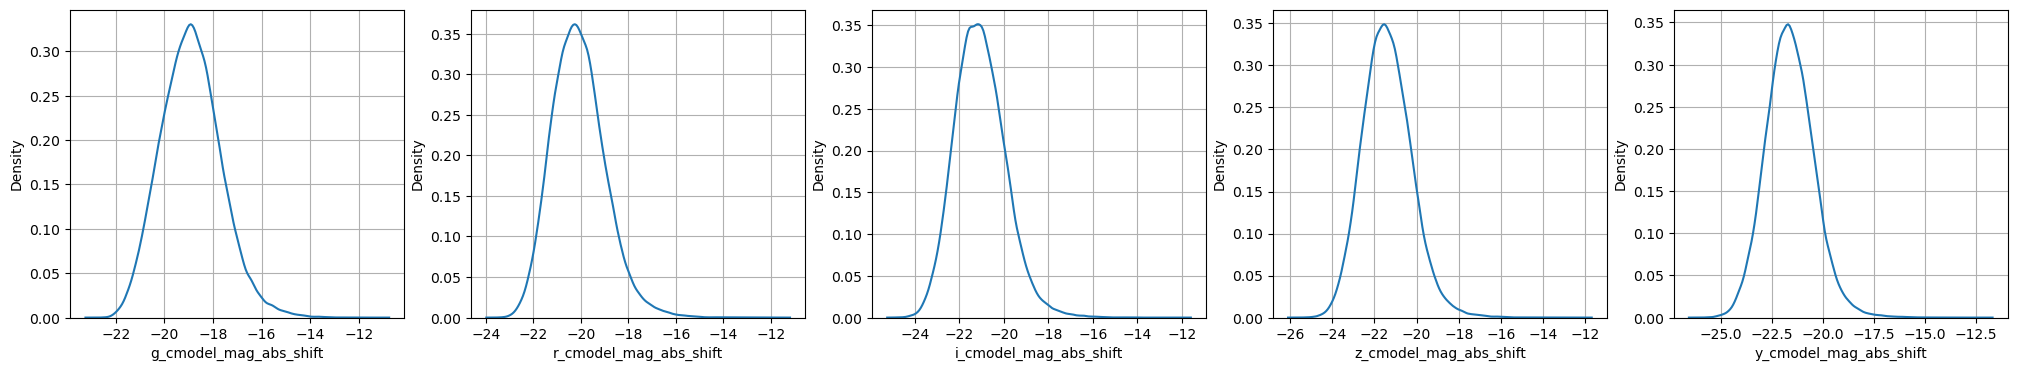

In [29]:
plt.figure(figsize = (25,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    sns.kdeplot(data = df, x = magnitudes[i] + '_abs_shift')
    plt.grid()

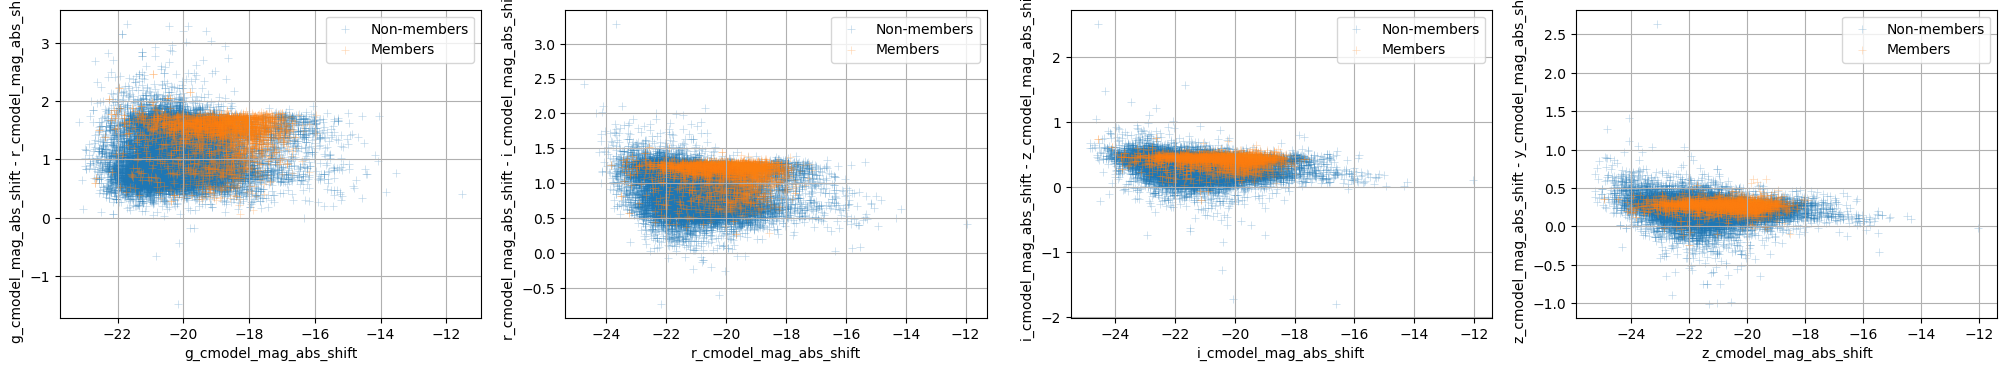

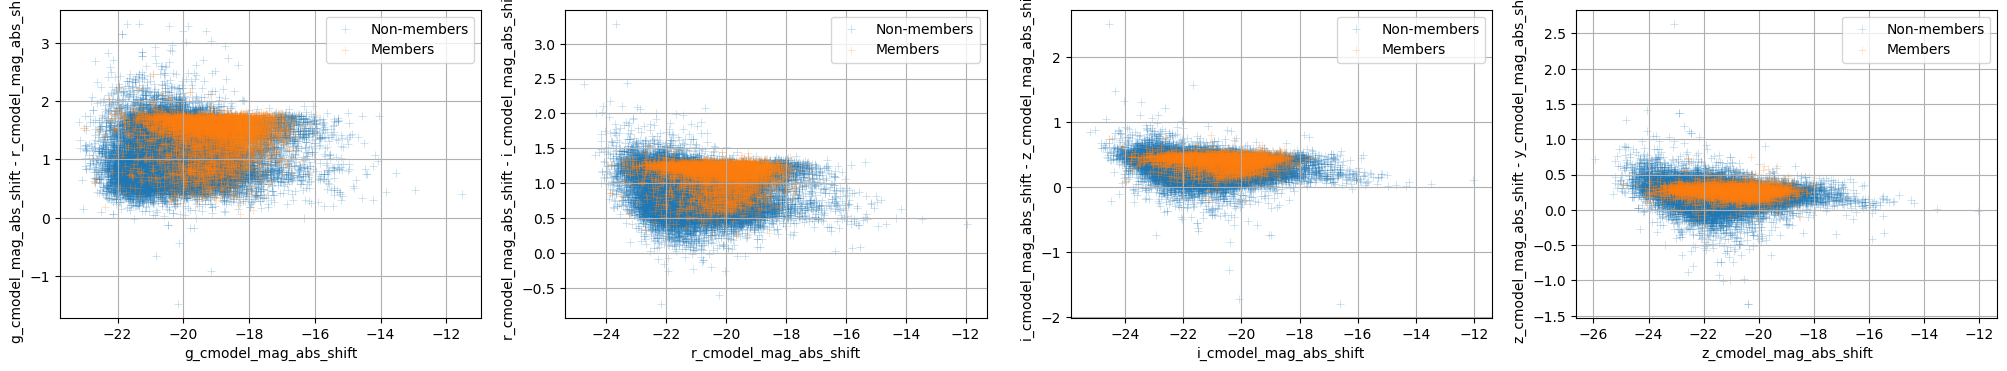

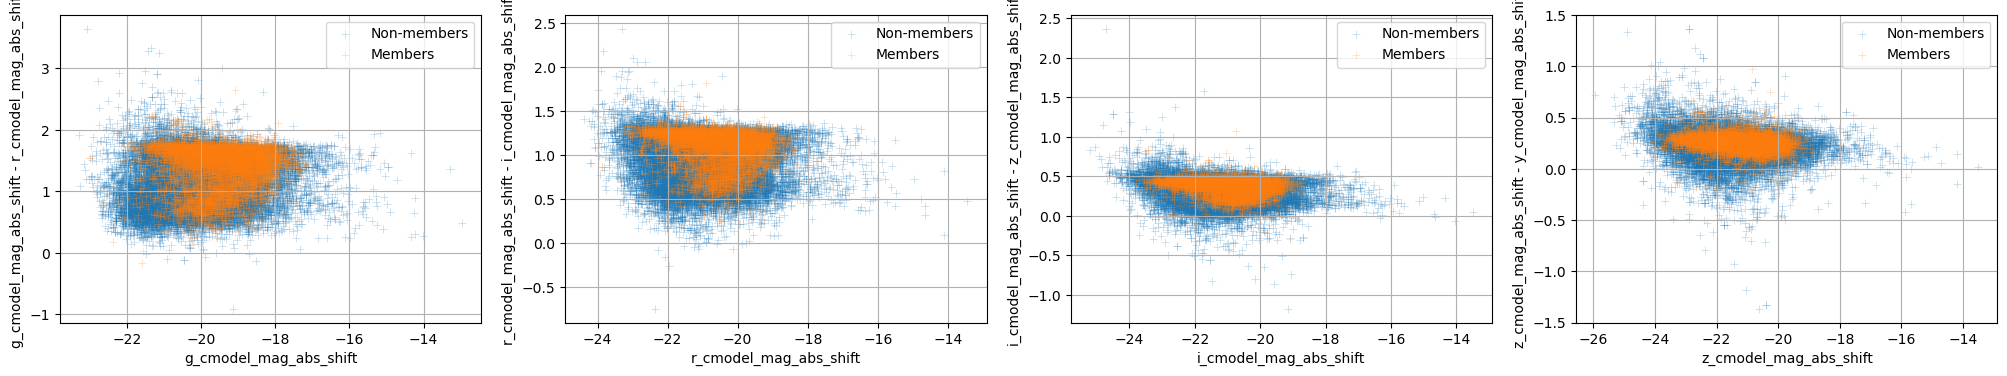

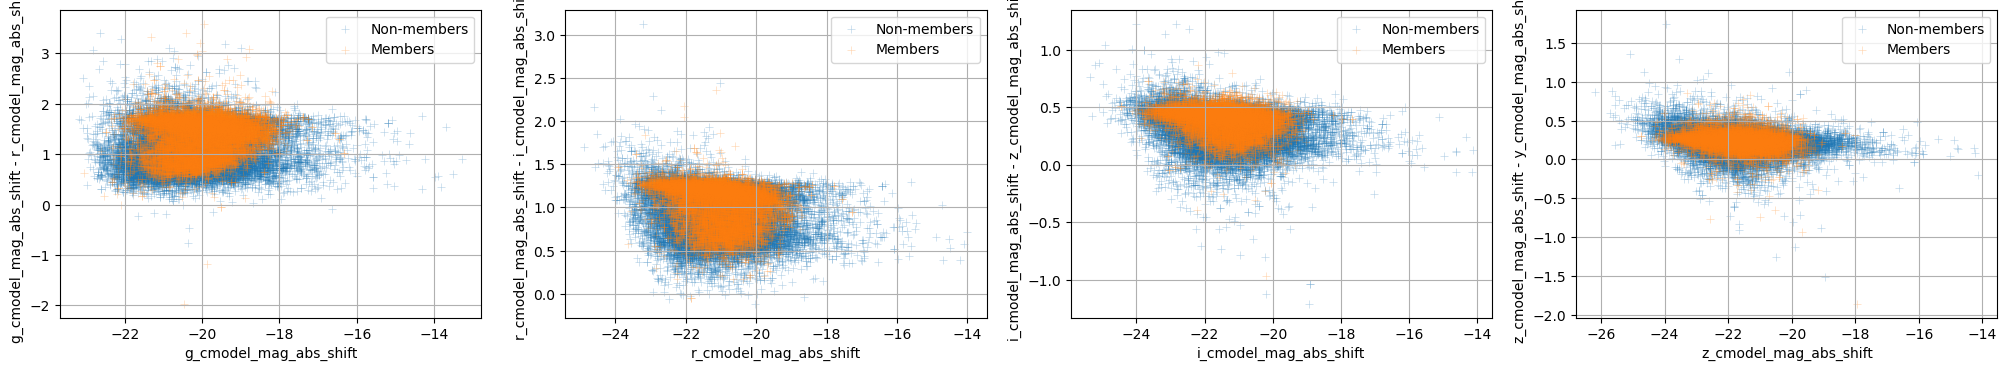

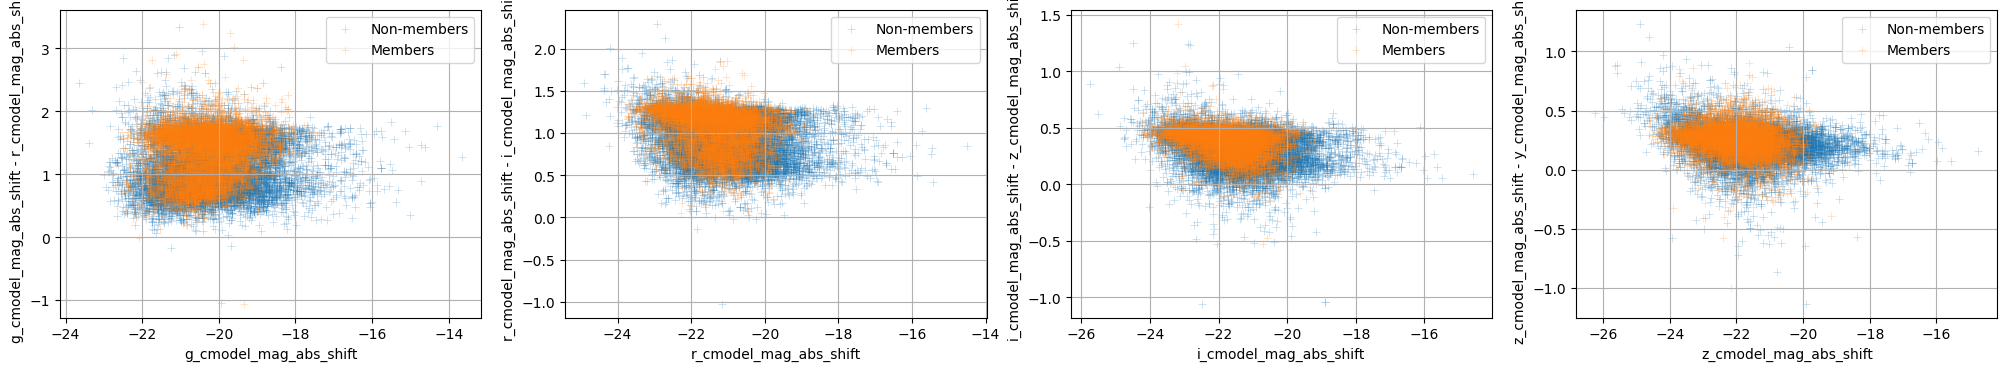

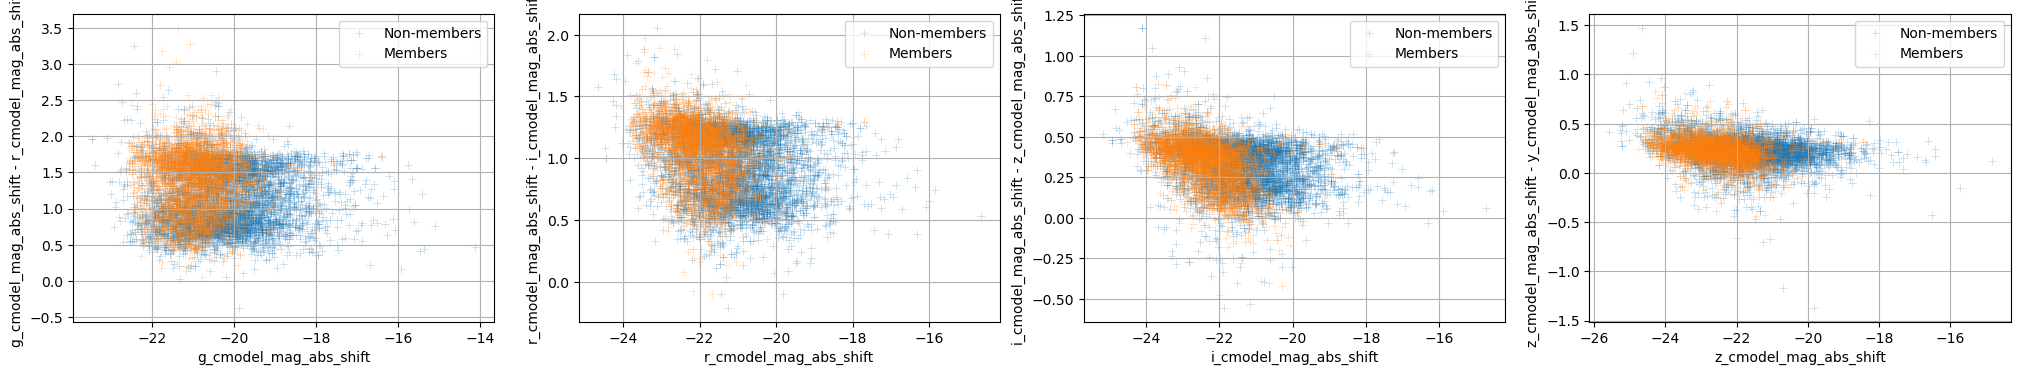

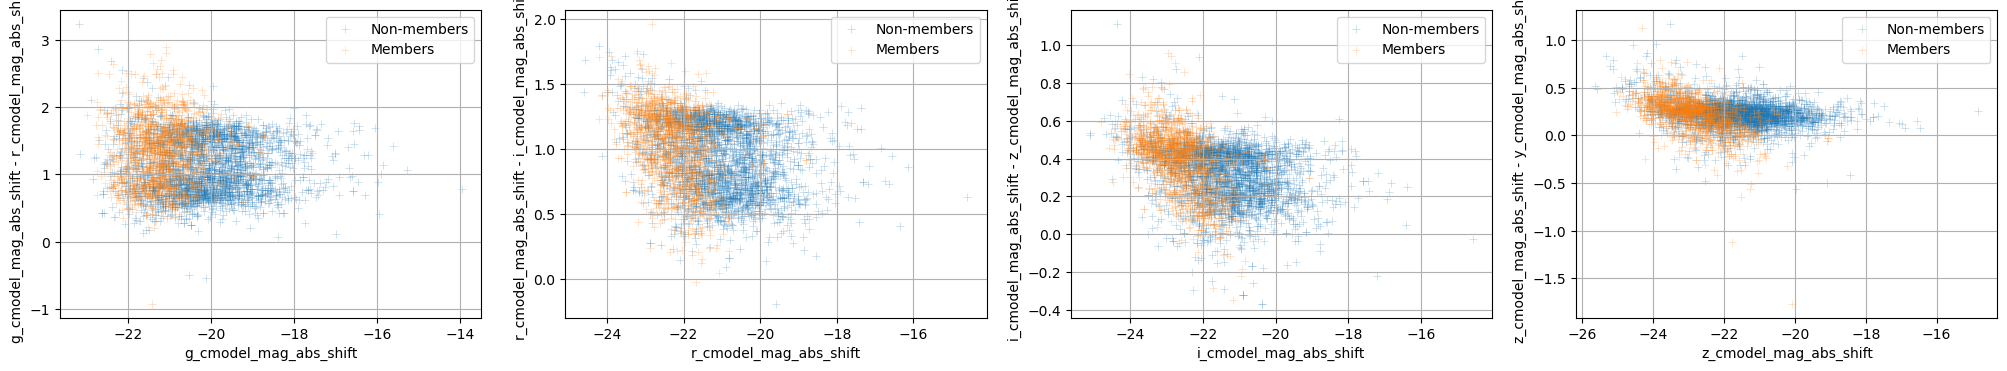

In [36]:
for z_min in [0, 0.1,0.25,0.5,0.7,1.,1.25]:
    z_max = z_min + 0.25

    cond = (df_.z_cl > z_min ) & (df_.z_cl < z_max )
    mem = df[(df.member == 1) & cond] 
    nmem = df[(df.member == 0) & cond]

    plt.figure(figsize = (25,4))
    for i in range(4):
        plt.subplot(1,4,i+1)
        sns.scatterplot(y = nmem[magnitudes[i] + '_abs_shift'] - nmem[magnitudes[i+1] + '_abs_shift'], x = nmem[magnitudes[i+1]+ '_abs_shift'], marker = '+', alpha = 0.3, label = 'Non-members')
        sns.scatterplot(y = mem[magnitudes[i] + '_abs_shift'] - mem[magnitudes[i+1] + '_abs_shift'], x = mem[magnitudes[i+1]+ '_abs_shift'], marker = '+', alpha = 0.3, label = 'Members')
        plt.grid()
        plt.xlabel(f'{magnitudes[i]}_abs_shift')
        plt.ylabel(f'{magnitudes[i]}_abs_shift - {magnitudes[i+1]}_abs_shift')
    plt.show()

### CSV

In [31]:
df.to_csv('clean-HSC-unWISE-W01--kcorr_tests.csv')

In [5]:
df = pd.read_csv('clean-HSC-unWISE-W01--kcorr_tests.csv')